**Repository:**  
https://github.com/rano667/AdEase-Timeseries-Forecasting

**Notebooks:**  
EDA → https://colab.research.google.com/drive/1es8O-Ty2oBzPK6wwC4UDU3b68bC9VzM9?usp=sharing  
Modeling → https://colab.research.google.com/drive/13y0h8tMvqw8_c0UUnRJQ2YTZoyvXWODq?usp=sharing


# 📌 Overall Project Plan for AdEase Time Series




## 1. Problem Understanding & Setup

- **Problem:** Forecast Wikipedia page views across 550 days for ~145k pages, split by title, language, access type, access origin, incorporating campaign effect (English only).

- **Business Use:** Predict traffic to optimize ad placements per language/region.

- **Models:**
  - ARIMA  
  - SARIMAX (with exogenous campaign data)  
  - Prophet (with exogenous campaign data)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import warnings
warnings.filterwarnings("ignore")

## 2. Data Import, Initial Exploration & handle null values

### ✅ Tasks:
- Load `train_1.csv` and `Exog_Campaign_eng`.  
- Check size, columns, and missing values.  
- Verify date columns (should start around 2015–2017).  
- Handle **null values** (likely 0 views → fill with 0).


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Wikipedia/train_1.csv")

In [ ]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
print("shape:", train.shape)
print("total missing values:", train.isnull().sum().sum())

shape: (145063, 551)
total missing values: 6192931


#### Missingness diagnostics & baseline cleaning choice

In [ ]:
train['Page'].isnull().sum()

np.int64(0)

- no missing value in Page column only missing value in date columns. We will handle them next.

In [ ]:
# detect date columns robustly
date_cols = [c for c in train.columns if re.match(r'^\d{4}-\d{2}-\d{2}$', c)]
print("num date cols:", len(date_cols))
print("first / last date columns:", date_cols[0], date_cols[-1])
# convert date list to datetime for plotting use
dates = pd.to_datetime(date_cols)

num date cols: 550
first / last date columns: 2015-07-01 2016-12-31


In [ ]:
# recompute missing counts if not present
train['missing_count'] = train[date_cols].isnull().sum(axis=1)
train['missing_pct'] = train['missing_count'] / len(date_cols) * 100

print("Total missing values (cells):", train[date_cols].isnull().sum().sum())
print("Pages with all dates missing:", (train['missing_count'] == len(date_cols)).sum())
print("Pages with >50% missing:", (train['missing_pct'] > 50).sum())
print("Pages with >20% missing:", (train['missing_pct'] > 20).sum())

Total missing values (cells): 6192931
Pages with all dates missing: 652
Pages with >50% missing: 10484
Pages with >20% missing: 18536


In [ ]:
# # Recommended baseline for EDA & modeling: drop rows that are ALL-NaN, then fill remaining NaNs with 0
# train_clean = train.loc[train['missing_count'] != len(date_cols)].copy()
# train_clean[date_cols] = train_clean[date_cols].fillna(0)

# print("train_clean shape:", train_clean.shape)
# print("total missing after baseline fill:", train_clean[date_cols].isnull().sum().sum())

In [ ]:
train.sample(10)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,missing_count,missing_pct
96894,Congruencia_(geometría)_es.wikipedia.org_mobil...,419.0,444.0,297.0,189.0,286.0,377.0,410.0,408.0,397.0,...,54.0,38.0,90.0,76.0,114.0,134.0,114.0,70.0,0,0.0
10479,Syrian_civil_war_en.wikipedia.org_desktop_all-...,580.0,588.0,491.0,616.0,624.0,576.0,598.0,603.0,687.0,...,562.0,470.0,531.0,538.0,530.0,517.0,439.0,2424.0,0,0.0
126685,Варкрафт_(фильм)_ru.wikipedia.org_all-access_s...,2.0,1.0,7.0,5.0,2.0,20.0,3.0,6.0,30.0,...,31.0,35.0,32.0,31.0,32.0,31.0,31.0,33.0,0,0.0
88964,Androidのバージョン履歴_ja.wikipedia.org_desktop_all-a...,779.0,739.0,746.0,433.0,385.0,789.0,717.0,808.0,816.0,...,132.0,119.0,227.0,232.0,215.0,159.0,154.0,129.0,0,0.0
71974,José_Hernández_es.wikipedia.org_desktop_all-ag...,1707.0,336.0,211.0,150.0,229.0,356.0,390.0,308.0,264.0,...,40.0,37.0,57.0,61.0,56.0,57.0,55.0,35.0,0,0.0
126641,"Еприкян,_Наталья_Андреевна_ru.wikipedia.org_al...",5.0,1.0,8.0,12.0,4.0,3.0,5.0,7.0,10.0,...,12.0,10.0,7.0,10.0,3.0,32.0,12.0,12.0,0,0.0
107564,聲之形_zh.wikipedia.org_mobile-web_all-agents,10.0,10.0,25.0,20.0,19.0,10.0,10.0,21.0,13.0,...,137.0,136.0,133.0,145.0,123.0,144.0,260.0,178.0,0,0.0
18326,"Хьюстон,_Уитни_ru.wikipedia.org_mobile-web_all...",312.0,390.0,391.0,325.0,378.0,485.0,316.0,247.0,462.0,...,431.0,533.0,1428.0,578.0,433.0,468.0,619.0,542.0,0,0.0
12668,Stan_Lee_en.wikipedia.org_desktop_all-agents,3857.0,3070.0,2265.0,2010.0,2163.0,2845.0,2722.0,2673.0,2608.0,...,1897.0,1291.0,1689.0,2858.0,11252.0,7967.0,3296.0,2305.0,0,0.0
14956,"File:Bruno_Mars,_Las_Vegas_2010.jpg_commons.wi...",3.0,3.0,5.0,3.0,1.0,4.0,6.0,9.0,8.0,...,102.0,177.0,148.0,237.0,215.0,184.0,215.0,87.0,0,0.0


Sample pages with leading NaNs:


,Page,missing_pct
27898,Décès_en_février_2016_fr.wikipedia.org_all-acc...,38.727273
3827,W_(電視劇)_zh.wikipedia.org_all-access_spider,40.545455
90121,特別:フィード項目/featured/20161010000000/ja_ja.wikipe...,92.909091
55633,Ousmane_Dembélé_fr.wikipedia.org_mobile-web_al...,36.181818
15823,"File:Feuerzeichen,_1979,_ein_Film_von_Herbert_...",76.181818



Sample pages with internal NaNs:


,Page,missing_pct
138385,Nicole_Schmidhofer_de.wikipedia.org_all-access...,0.909091
86997,名古屋西本線料金所_ja.wikipedia.org_desktop_all-agents,0.363636
80071,File:Wembleyold.jpg_commons.wikimedia.org_mobi...,42.727273
84090,Help:CirrusSearch/ar_www.mediawiki.org_all-acc...,6.727273
42164,Category:Extensions/pt-br_www.mediawiki.org_de...,0.363636



Sample pages with trailing NaNs:


,Page,missing_pct
99912,Категория:Гидра_(созвездие)_ru.wikipedia.org_a...,44.363636
15678,File:Zeitschrift_des_Vereins_fuer_Volkskunde_2...,91.454545
109878,Asceua_en.wikipedia.org_all-access_all-agents,99.636364
64829,是松豐三郎_zh.wikipedia.org_desktop_all-agents,100.000000
45102,User:CallieGraham09_commons.wikimedia.org_all-...,88.181818



Visualizing sample pages with leading NaNs:


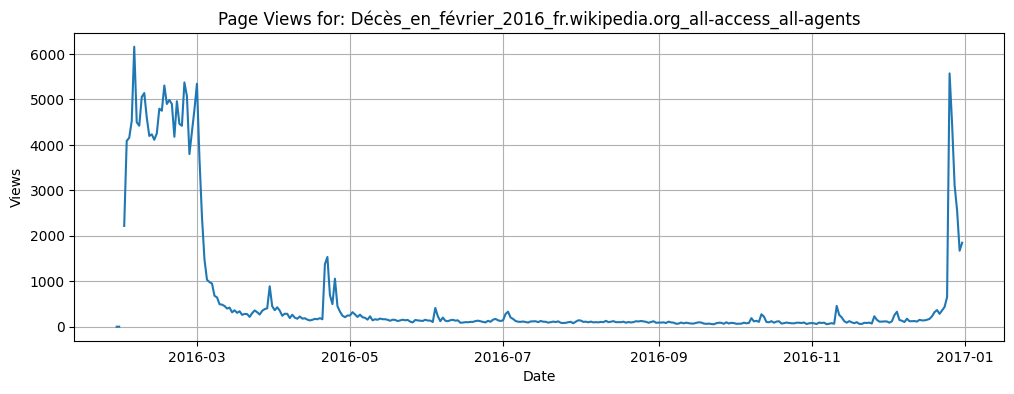

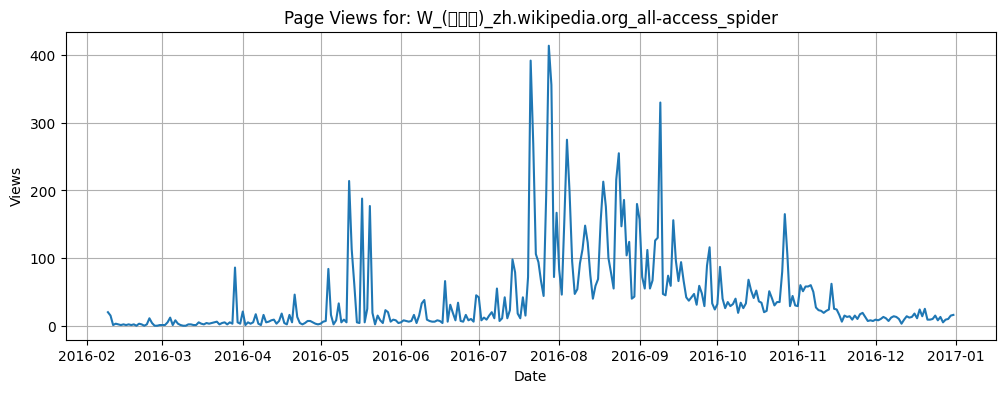

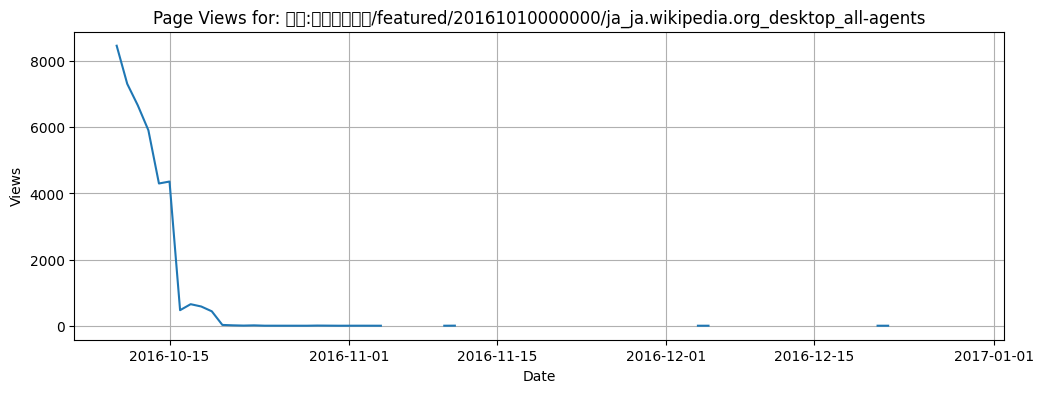

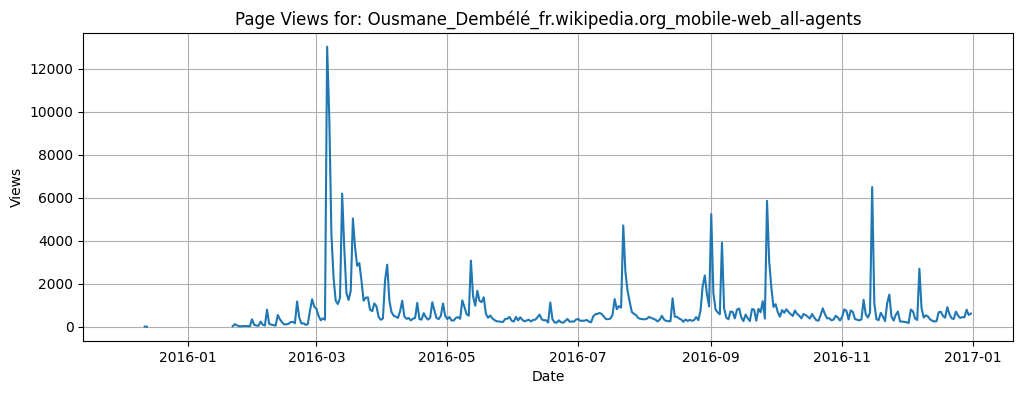

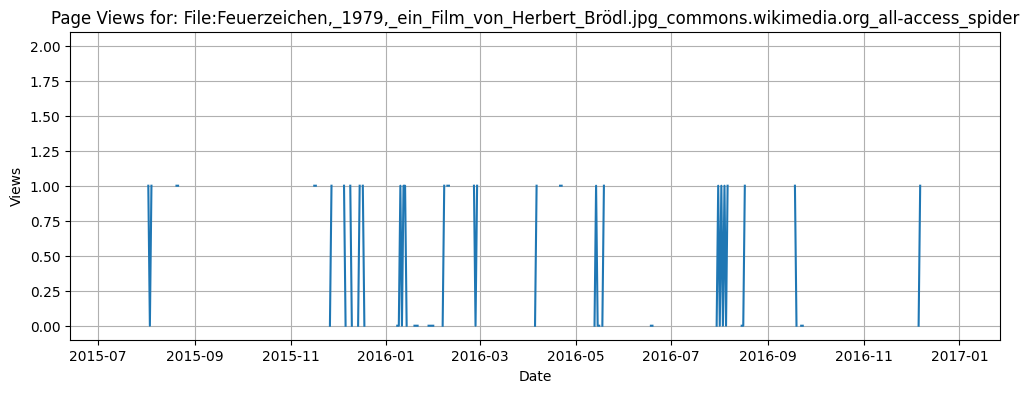


Visualizing sample pages with internal NaNs:


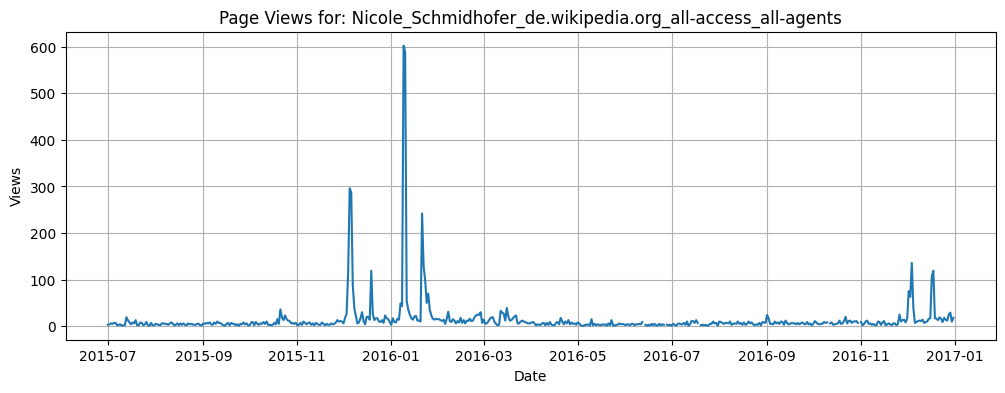

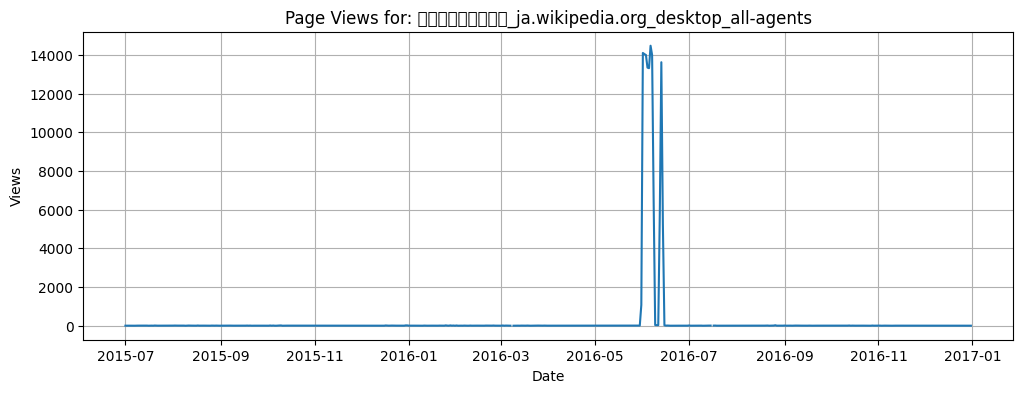

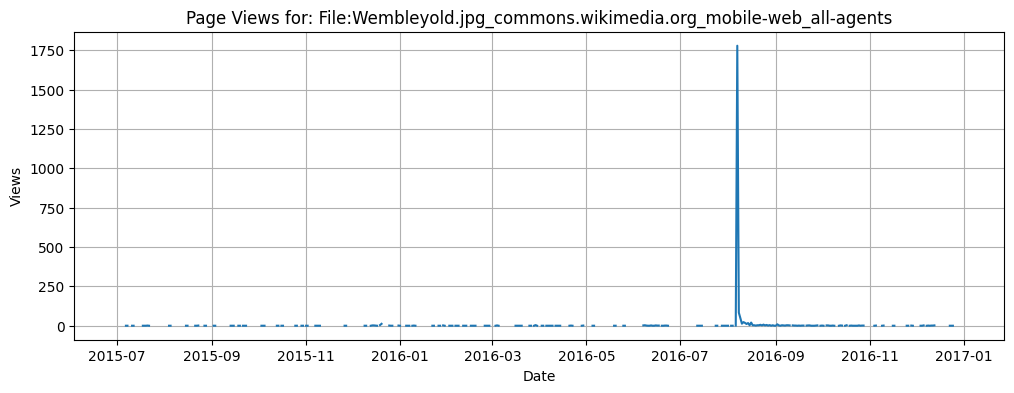

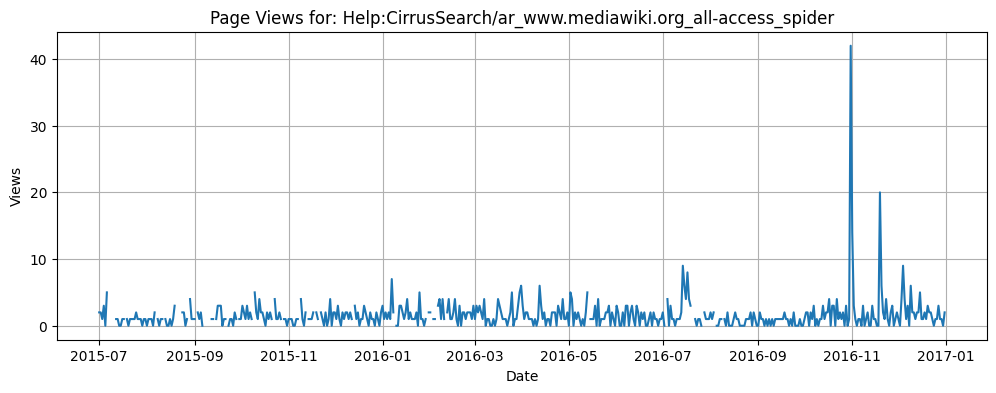

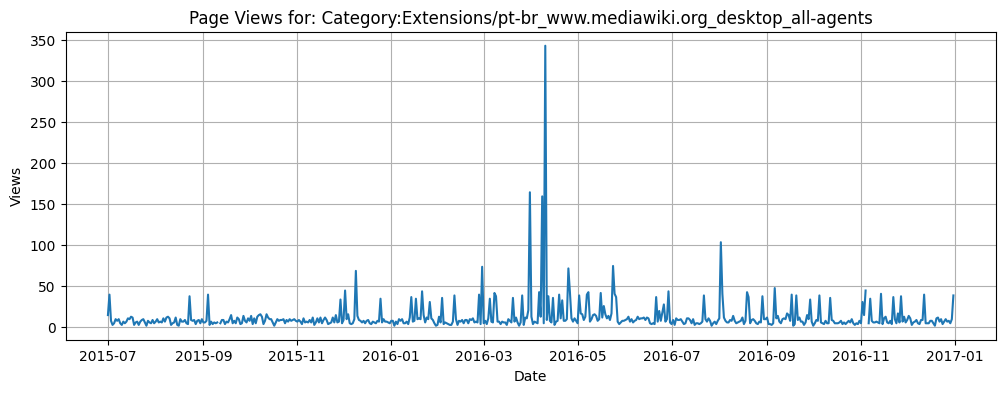


Visualizing sample pages with trailing NaNs:


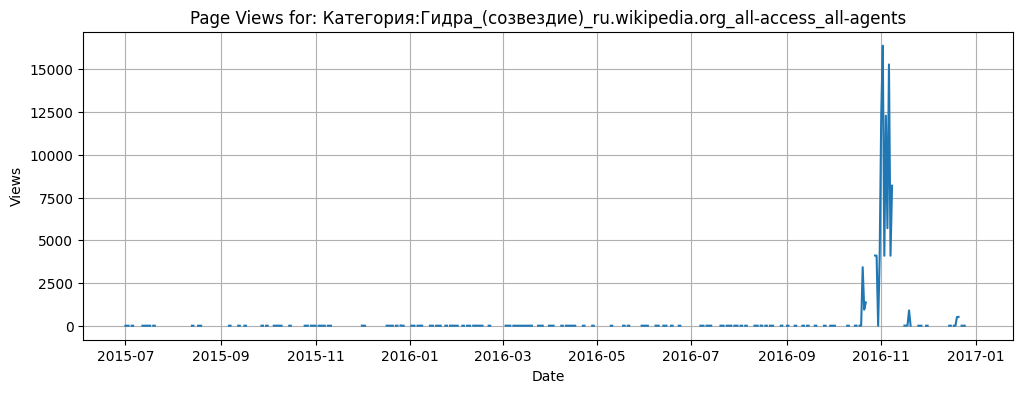

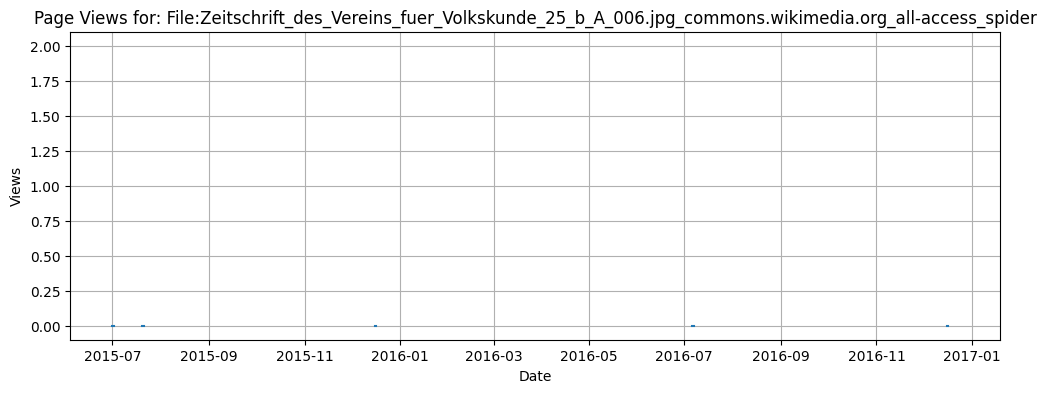

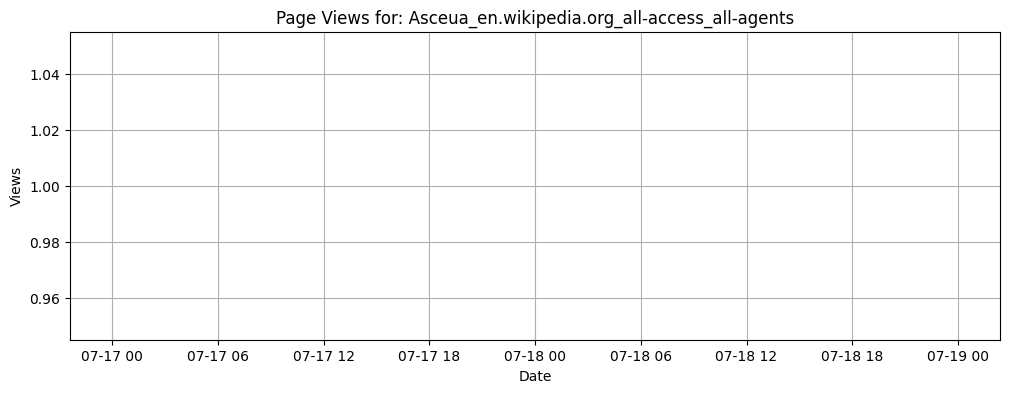

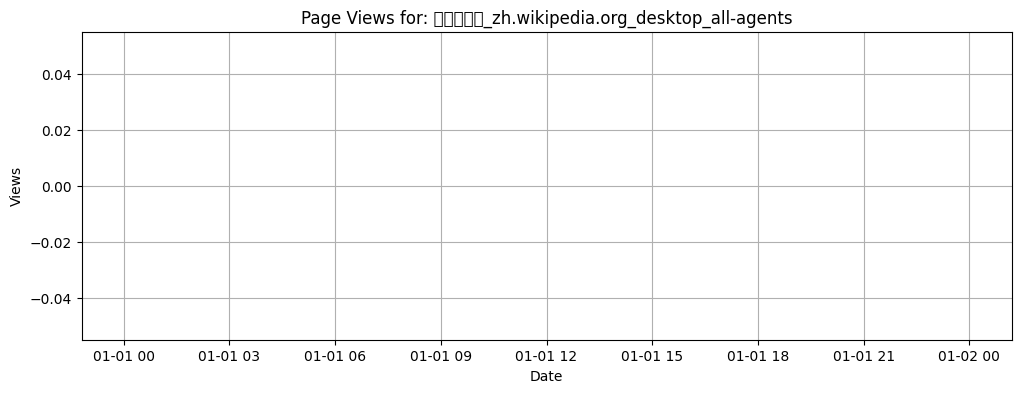

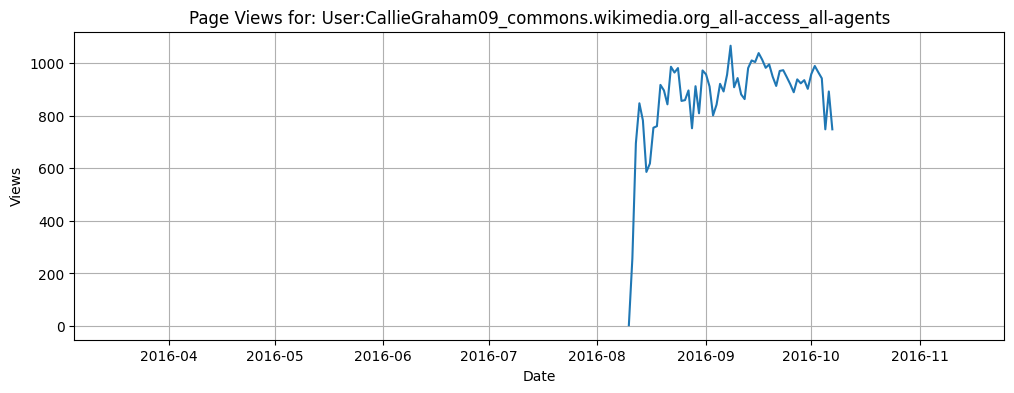

In [ ]:
# Identify pages with NaNs at the beginning
pages_with_leading_nans = train[train[date_cols[0]].isnull()]

# Identify pages with NaNs somewhere in between (not just leading or trailing)
# This is a bit more complex. We can check if there are NaNs and if the first and last values are not NaN.
# This is a simplification, as NaNs could be in the middle even if the first/last are NaN,
# but it helps differentiate from purely leading/trailing NaNs for visualization purposes.
pages_with_internal_nans = train[
    (train[date_cols].isnull().sum(axis=1) > 0) & # has some missing values
    (train[date_cols[0]].notnull()) & # but not missing at the very start
    (train[date_cols[-1]].notnull()) # and not missing at the very end
]

# Identify pages with NaNs at the end
pages_with_trailing_nans = train[train[date_cols[-1]].isnull()]


# Select a few sample pages from each category for visualization
sample_leading_nan_pages = pages_with_leading_nans.sample(min(5, len(pages_with_leading_nans)), random_state=42)
sample_internal_nan_pages = pages_with_internal_nans.sample(min(5, len(pages_with_internal_nans)), random_state=42)
sample_trailing_nan_pages = pages_with_trailing_nans.sample(min(5, len(pages_with_trailing_nans)), random_state=42)


print("Sample pages with leading NaNs:")
display(sample_leading_nan_pages[['Page', 'missing_pct']].head())

print("\nSample pages with internal NaNs:")
display(sample_internal_nan_pages[['Page', 'missing_pct']].head())

print("\nSample pages with trailing NaNs:")
display(sample_trailing_nan_pages[['Page', 'missing_pct']].head())


# Function to plot a single page's time series
def plot_page_views(page_row, date_cols):
    page_name = page_row['Page']
    views = page_row[date_cols].astype(float)
    plt.figure(figsize=(12, 4))
    plt.plot(pd.to_datetime(date_cols), views)
    plt.title(f"Page Views for: {page_name}")
    plt.xlabel("Date")
    plt.ylabel("Views")
    plt.grid(True)
    plt.show()

# Visualize sample pages with leading NaNs
print("\nVisualizing sample pages with leading NaNs:")
for index, row in sample_leading_nan_pages.iterrows():
    plot_page_views(row, date_cols)

# Visualize sample pages with internal NaNs
print("\nVisualizing sample pages with internal NaNs:")
for index, row in sample_internal_nan_pages.iterrows():
     plot_page_views(row, date_cols)

# Visualize sample pages with trailing NaNs
print("\nVisualizing sample pages with trailing NaNs:")
for index, row in sample_trailing_nan_pages.iterrows():
     plot_page_views(row, date_cols)

In [ ]:
# all_nan count
train[train['missing_pct'] == 100].shape[:1]

(652,)

In [ ]:
# Helper to classify NaN pattern for each row
def classify_nan_pattern(row, date_cols):
    values = row[date_cols].values
    isnan = pd.isna(values)

    if isnan.all():
        return "all_nan"

    # Find first and last non-NaN indices
    first_valid = (~isnan).argmax()
    last_valid = len(isnan) - 1 - (~isnan[::-1]).argmax()

    leading = first_valid > 0
    trailing = last_valid < len(isnan) - 1
    internal = isnan[first_valid:last_valid+1].any()

    if leading and not trailing and not internal:
        return "leading_only"
    elif trailing and not leading and not internal:
        return "trailing_only"
    elif leading and trailing and not internal:
        return "leading_and_trailing"
    elif internal:
        return "internal"
    else:
        return "no_missing"

# Apply classification
train['nan_pattern'] = train.apply(lambda row: classify_nan_pattern(row, date_cols), axis=1)

# Count results
nan_pattern_counts = train['nan_pattern'].value_counts()
print(nan_pattern_counts)


nan_pattern
no_missing              117277
internal                 15591
leading_only             11321
all_nan                    652
leading_and_trailing       186
trailing_only               36
Name: count, dtype: int64


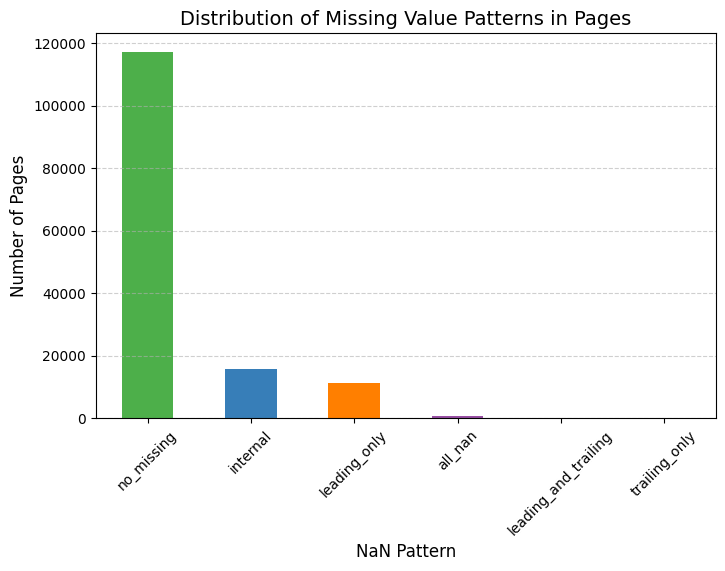

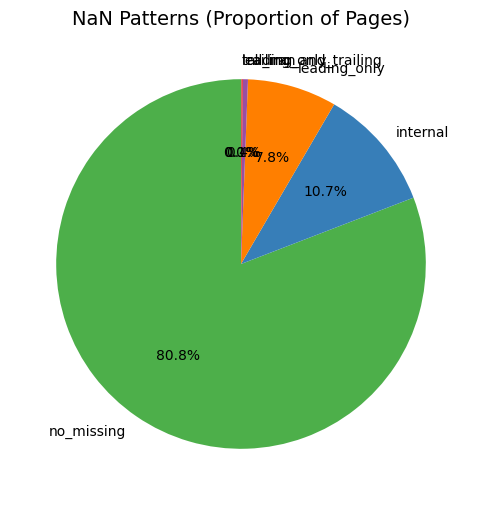

In [ ]:
# Count patterns
nan_pattern_counts = train['nan_pattern'].value_counts()

# plot stacked bar chart to visualize the distribution
plt.figure(figsize=(8,5))
nan_pattern_counts.plot(
    kind="bar",
    color=["#4daf4a", "#377eb8", "#ff7f00", "#984ea3", "#e41a1c", "#999999"]
)
plt.title("Distribution of Missing Value Patterns in Pages", fontsize=14)
plt.xlabel("NaN Pattern", fontsize=12)
plt.ylabel("Number of Pages", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

# percentage view (to compare proportions)
plt.figure(figsize=(6,6))
(nan_pattern_counts / nan_pattern_counts.sum() * 100).plot(
    kind="pie",
    autopct="%.1f%%",
    startangle=90,
    colors=["#4daf4a", "#377eb8", "#ff7f00", "#984ea3", "#e41a1c", "#999999"]
)

plt.title("NaN Patterns (Proportion of Pages)", fontsize=14)
plt.ylabel("")  # remove default y-label
plt.show()


### 🔎 Handling Missing Values in Page View Series

#### 1. Leading NaNs (before the series starts)
- **Likely cause:** Page didn’t exist yet (new page created after 2015).  
- **Meaning:** Structural missing values, not true gaps.  
- **Best strategies:**  
  - Fill with **0s** → page didn’t exist, so views = 0 is valid.  
  - Alternatively, leave as **NaN** if you want to explicitly model "page not yet created."  
- 👉 **Recommended:** Fill with **0s** (common in competitions/research papers).  

---

#### 2. Internal NaNs (gaps in the middle of the series)
- **Likely cause:** Logging/collection issues, temporary data drop, or bot/spam detection filters.  
- **Meaning:** True missing values (traffic existed but wasn’t captured).  
- **Best strategies:**  
  - **Forward/Backward fill** → propagate nearby values (good for short gaps).  
  - **Linear interpolation** → smooth across missing days.  
  - **Rolling mean imputation** → fill using average of nearby window (e.g., 7 days).  
  - ⚠️ Avoid **global 0-filling** → introduces fake inactivity.  
- 👉 **Recommended:** Interpolation or forward/backfill depending on gap size.  

---

#### 3. Trailing NaNs (after the series ends)
- **Likely cause:** Page deleted or stopped being tracked.  
- **Meaning:** Structural missing values (page ceased to exist).  
- **Best strategies:**  
  - Fill with **0s** → no views after deletion.  
  - Optionally **drop page** if very high % missing (e.g., >90%).  
- 👉 **Recommended:** Fill with **0s**.  

---

#### ⚖️ Hybrid Imputation Policy
- **Leading NaNs** → fill with **0**.  
- **Trailing NaNs** → fill with **0**.  
- **Internal NaNs** → use **interpolation** (linear or forward/backward fill).  
- **All-NaN pages** (e.g., page 652) → **drop** (no useful data).  


In [ ]:
sample_trailing_nan_pages['Page'].to_list()

['Категория:Гидра_(созвездие)_ru.wikipedia.org_all-access_all-agents',
 'File:Zeitschrift_des_Vereins_fuer_Volkskunde_25_b_A_006.jpg_commons.wikimedia.org_all-access_spider',
 'Asceua_en.wikipedia.org_all-access_all-agents',
 '是松豐三郎_zh.wikipedia.org_desktop_all-agents',
 'User:CallieGraham09_commons.wikimedia.org_all-access_all-agents']

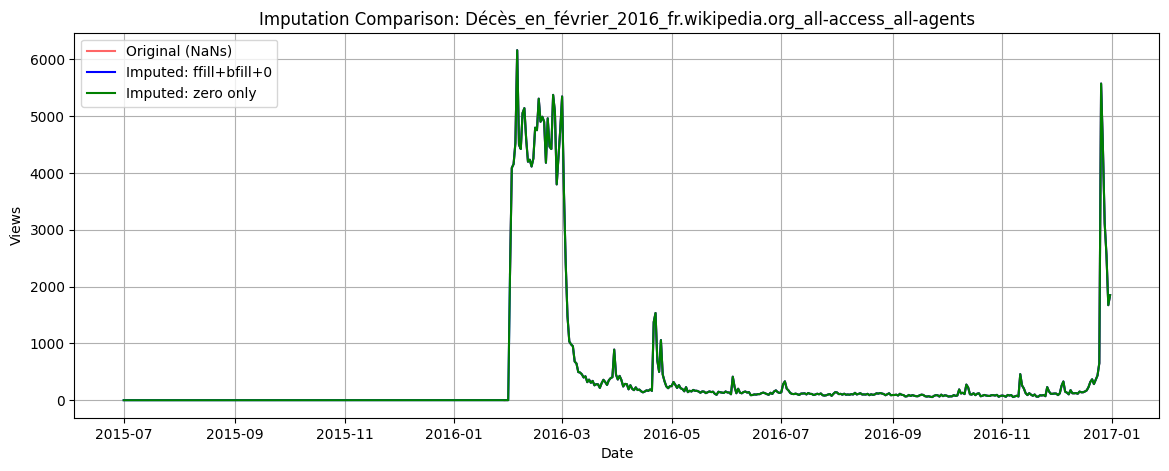

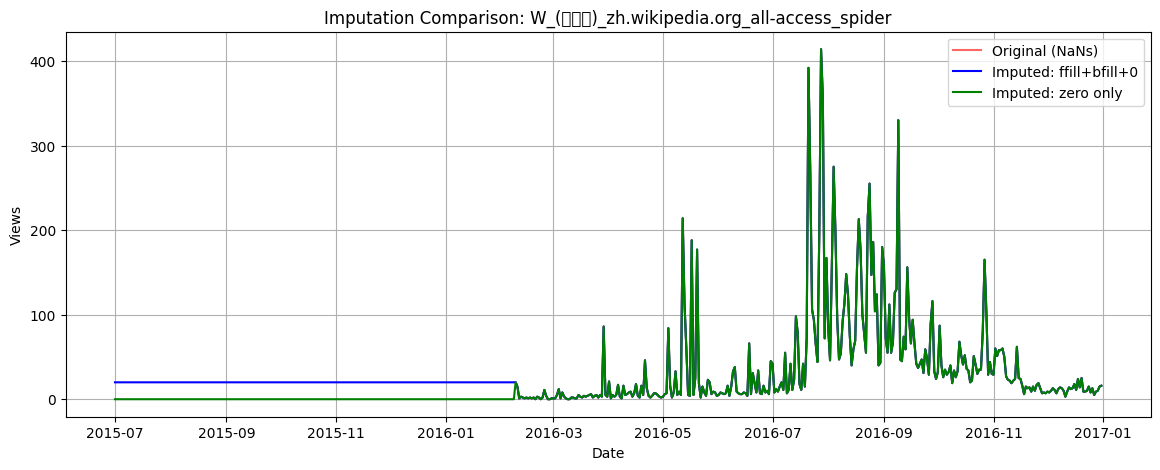

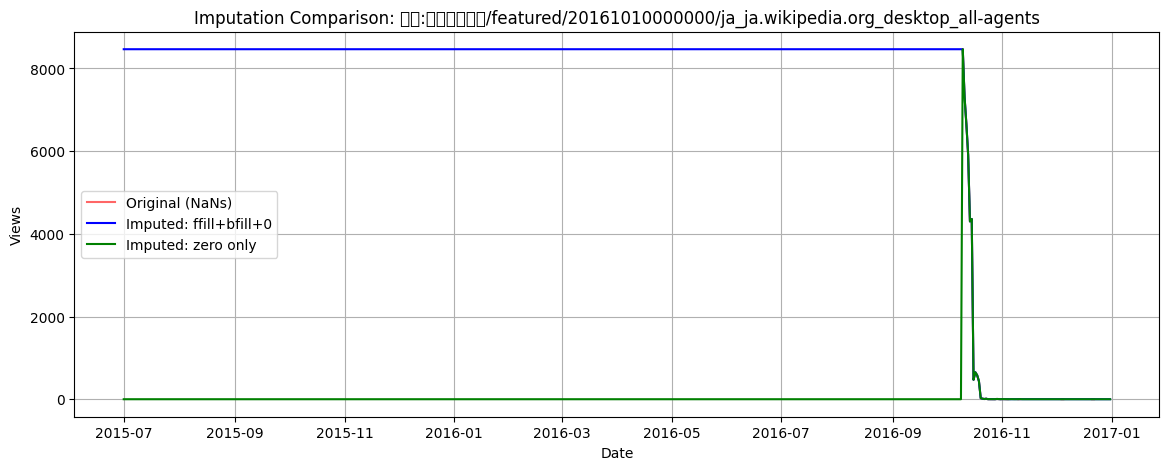

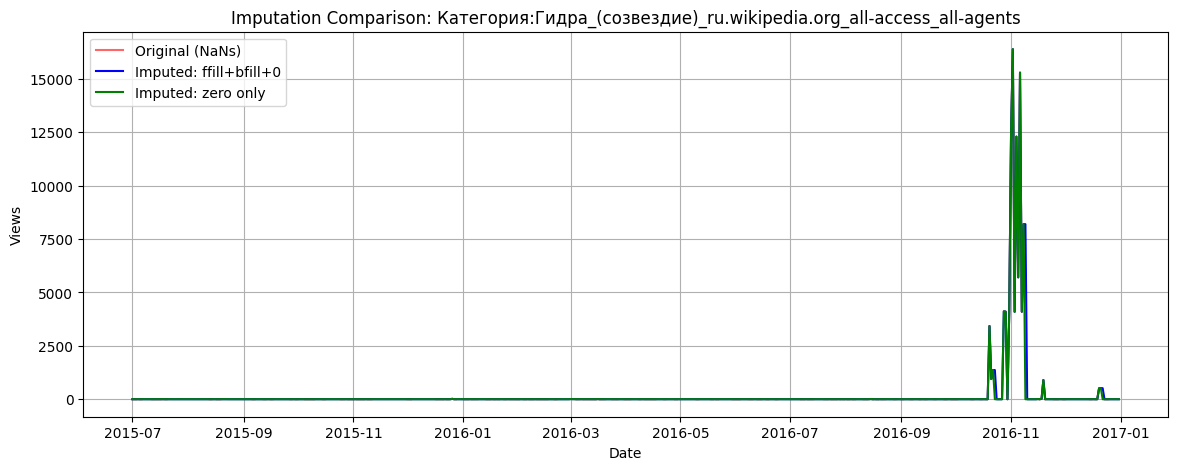

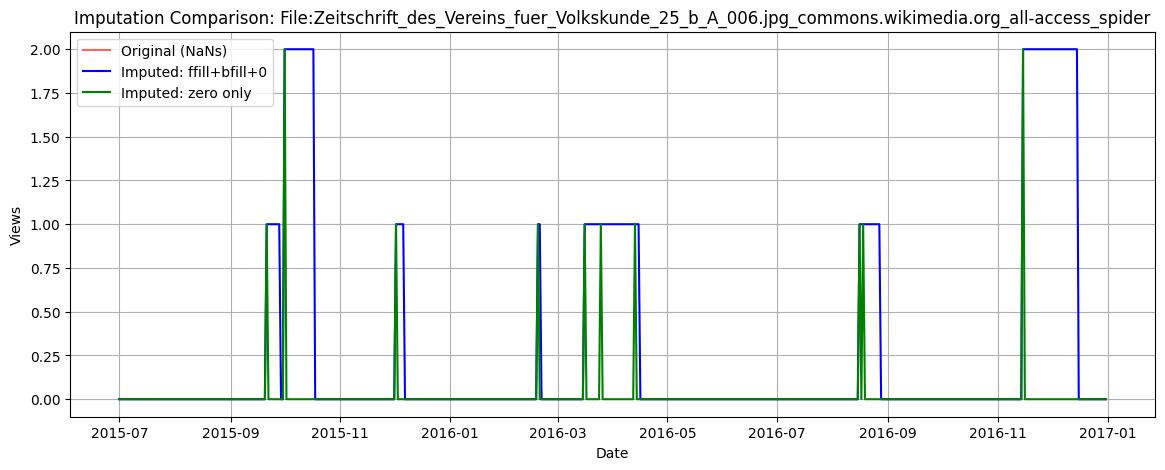

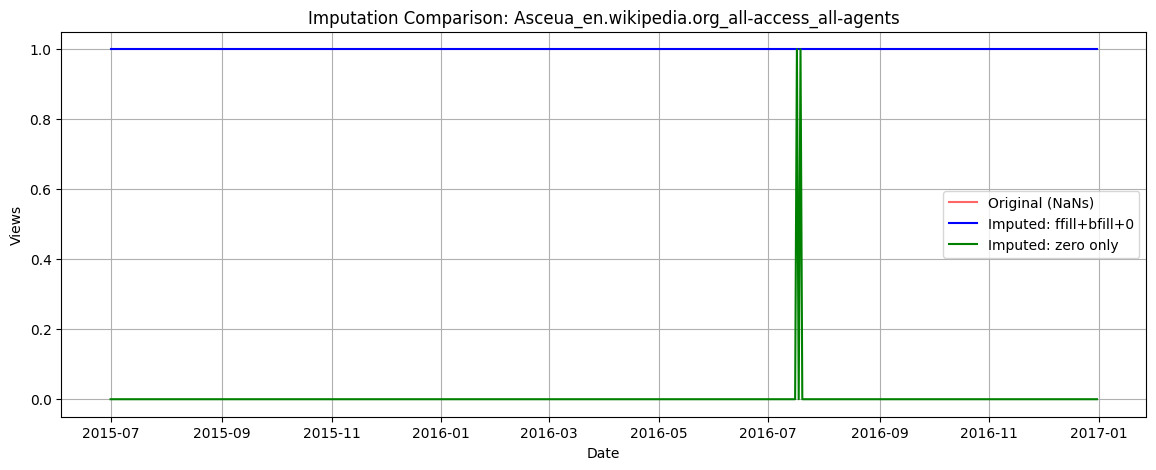

In [ ]:
# --- Create both imputation strategies ---
def impute_ffill_bfill(df, date_cols):
    filled = df.copy()
    filled = filled[filled[date_cols].notna().any(axis=1)]
    # Forward + backward fill, then 0
    filled[date_cols] = (
        filled[date_cols]
        .fillna(method='ffill', axis=1)
        .fillna(method='bfill', axis=1)
        .fillna(0)
    )
    filled[date_cols] = filled[date_cols].interpolate(axis=1, limit_direction='both')
    return filled

def impute_zero_only(df, date_cols):
    filled = df.copy()
    filled = filled[date_cols].notna().any(axis=1)
    # Directly set missing to 0 (leading/trailing)
    filled = df[df[date_cols].notna().any(axis=1)].copy()
    filled[date_cols] = filled[date_cols].fillna(0)
    filled[date_cols] = filled[date_cols].interpolate(axis=1, limit_direction='both')
    return filled

train_imputed_ffill = impute_ffill_bfill(train, date_cols)
train_imputed_zero = impute_zero_only(train, date_cols)


# --- Plot comparison ---
def plot_imputation_comparison(page_row, date_cols, df_ffill, df_zero):
    page_name = page_row['Page']
    idx = page_row.name

    original = page_row[date_cols].astype(float)
    page_name = row['Page']

    ffill_vals = df_ffill.loc[df_ffill['Page'] == page_name, date_cols].iloc[0].astype(float)
    zero_vals  = df_zero.loc[df_zero['Page'] == page_name, date_cols].iloc[0].astype(float)

    dates = pd.to_datetime(date_cols)

    plt.figure(figsize=(14, 5))
    plt.plot(dates, original, label="Original (NaNs)", color="red", alpha=0.6)
    plt.plot(dates, ffill_vals, label="Imputed: ffill+bfill+0", color="blue")
    plt.plot(dates, zero_vals, label="Imputed: zero only", color="green")

    plt.title(f"Imputation Comparison: {page_name}")
    plt.xlabel("Date")
    plt.ylabel("Views")
    plt.legend()
    plt.grid(True)
    plt.show()


# Example: compare for 3 leading-NaN sample pages
for idx, row in sample_leading_nan_pages.head(3).iterrows():
    plot_imputation_comparison(row, date_cols, train_imputed_ffill, train_imputed_zero)

# Example: compare for 3 trailing-NaN sample pages
for idx, row in sample_trailing_nan_pages.head(3).iterrows():
    plot_imputation_comparison(row, date_cols, train_imputed_ffill, train_imputed_zero)


In [ ]:
def impute_page_views(df, date_cols):
    filled = df.copy()

    # 1. Drop rows where all dates are NaN
    filled = filled[filled[date_cols].notna().any(axis=1)]

    # 2. Fill leading/trailing NaNs with 0
    filled[date_cols] = (
        filled[date_cols]
        .fillna(0)                        # if still NaN, set to 0
    )

    # 3. Interpolate internal NaNs
    filled[date_cols] = filled[date_cols].interpolate(
        axis=1,
        limit_direction='both'
    )

    return filled


# Apply hybrid imputation
train_imputed = impute_page_views(train, date_cols)

print("Shape after imputation:", train_imputed.shape)
print("Total missing after imputation:", train_imputed[date_cols].isnull().sum().sum())


Shape after imputation: (144411, 554)
Total missing after imputation: 0


#### Remove never-viewed pages (flatlined zeros)
- **Low-traffic/noisy pages:** A subset of pages (flatlined at zero) provide negligible signal and can be excluded to reduce noise in downstream models.

##### 📏 Practical Rule of Thumb for Filtering Pages

- **eps = 1**  
  - Removes pages averaging **<1 view/day**  
  - Over ~550 days → <550 total views  
  - ✅ Good baseline to keep only meaningful pages  

- **eps = 5 or 10**  
  - Keeps only pages with at least **moderate recurring traffic**  
  - 🚀 More aggressive filtering  

- **eps = 0.1**  
  - Drops pages below **0.1 daily average** (~55 total views over dataset)  
  - 🛡️ Ultra-safe: only eliminates pages with almost no activity  


In [ ]:
def remove_zero_traffic_pages(df, date_cols, eps=1):
    """
    Remove pages with no real traffic:
    - mean_views <= eps
    - OR std_views <= eps (flatlined or near-flat)
    """
    if 'mean_views' not in df.columns or 'std_views' not in df.columns:
        df = df.copy()
        df['mean_views'] = df[date_cols].mean(axis=1)
        df['std_views'] = df[date_cols].std(axis=1)

    mask = ~(
        (df['mean_views'] <= eps) |
        (df['std_views'] <= eps)
    )
    cleaned = df[mask].copy()
    print(f"Removed {len(df) - len(cleaned)} near-zero traffic pages out of {len(df)}")
    return cleaned


In [ ]:
train_clean = remove_zero_traffic_pages(train_imputed, date_cols)

Removed 2226 near-zero traffic pages out of 144411


## 3. Page Name Parsing  

### ✅ Tasks:
- Split `Page` into:
  - **Title** (article name)  
  - **Language** (en, de, fr, etc.)  
  - **Access Type** (desktop, mobile, all-access)  
  - **Access Origin** (spider, all-agents)
- Quick diagnostics:
  - How many unique languages
  - Top languages by #pages
  - Missingness distribution by row (per page) and by column (per date)


In [ ]:
print("\nexample Page values:\n", train_clean['Page'].sample(10).to_list())


example Page values:
 ['王岐山_zh.wikipedia.org_all-access_all-agents', 'Альбус_Дамблдор_ru.wikipedia.org_all-access_spider', '西游记之孙悟空三打白骨精_zh.wikipedia.org_all-access_all-agents', 'カエンタケ_ja.wikipedia.org_desktop_all-agents', '訃報_2016年3月_ja.wikipedia.org_desktop_all-agents', 'A級戦犯_ja.wikipedia.org_all-access_spider', 'Category:Courageous_Cunts_commons.wikimedia.org_all-access_all-agents', '维基百科_zh.wikipedia.org_desktop_all-agents', 'Saison_5_de_The_Walking_Dead_fr.wikipedia.org_desktop_all-agents', 'Terminator:_Die_Erlösung_de.wikipedia.org_mobile-web_all-agents']


### ✅ Correct Parsing Logic

We need to handle **two cases** robustly:

1. `<title>_<lang>.wikipedia.org_<access>_<origin>`  
2. `<title>_commons.wikimedia.org_<access>_<origin>`  


In [ ]:
# Parse Page into components:
# Better approach with regex

def split_page_columns(s):
    # Case 1: language-specific Wikipedia
    m = re.match(r'^(.*)_(?P<lang>[a-z\-]+)\.wikipedia\.org_(?P<access>[^_]+)_(?P<origin>[^_]+)$', s)
    if m:
        return pd.Series([m.group(1), m.group("lang"), m.group("access"), m.group("origin")])

    # Case 2: Wikimedia Commons (no language, treat lang='commons')
    m = re.match(r'^(.*)_commons\.wikimedia\.org_(?P<access>[^_]+)_(?P<origin>[^_]+)$', s)
    if m:
        return pd.Series([m.group(1), "commons", m.group("access"), m.group("origin")])

    # Fallback: split by "_" and guess
    parts = s.split('_')
    title = "_".join(parts[:-3]) if len(parts) > 3 else parts[0]
    lang = parts[-3].split('.')[0] if len(parts) > 2 else np.nan
    access = parts[-2] if len(parts) > 1 else np.nan
    origin = parts[-1] if len(parts) > 0 else np.nan
    return pd.Series([title, lang, access, origin])

# Apply
train_clean[['Title','Language','AccessType','AccessOrigin']] = train_clean['Page'].apply(split_page_columns)


In [ ]:
# quick checks
print("\nUnique languages:", train_clean['Language'].nunique())
print("Top 10 languages by page count:\n", train_clean['Language'].value_counts().head(10))
print("\nAccess types:\n", train_clean['AccessType'].value_counts().head())
print("\nAccess origins:\n", train_clean['AccessOrigin'].value_counts().head())


Unique languages: 9
Top 10 languages by page count:
 Language
en         23728
ja         20321
de         18339
fr         17687
zh         17028
ru         14936
es         13990
commons     9575
www         6581
Name: count, dtype: int64

Access types:
 AccessType
all-access    72433
mobile-web    35269
desktop       34483
Name: count, dtype: int64

Access origins:
 AccessOrigin
all-agents    108645
spider         33540
Name: count, dtype: int64


### ✅ Handling `commons` and `www` in "languages"

- **commons** → Refers to **Wikimedia Commons** (shared media repository).  
  - Not tied to a specific language.  
- **www** → Refers to **www.wikipedia.org** (multilingual portal/homepage).  
  - Also not tied to a specific language edition.  

#### Key Points
- These are **valid projects**, not parsing errors.  
- They **don’t behave like real language editions** (e.g., en, ja, de).  

#### What You Can Do
1. ✅ **Keep them** if you want to capture *all traffic* across Wikipedia + sister projects.  
   - Includes Commons + homepage, which sometimes get huge traffic.  
2. 🚫 **Filter them out** if your focus is *strictly language editions*.  
   - Drop rows where `Language ∈ {commons, www}`.  
3. 🎯 **Tag them separately** for flexibility:  
   - Example: `ProjectType = "language-wiki"` vs `ProjectType = "other-wiki"`.  
   - Prevents mixing them into language-based stats while still preserving traffic info.  


## 4. Exploratory Data Analysis (EDA)  

### ✅ Tasks:
- Analyze **distribution of page views**.   
- Compare **views by language**.  
- Visualize **daily views for sample pages**.  

### 🎯 Deliverables for This Step

- **Global summary stats**  
  - Counts, date range, missingness overview  

- **Per-language statistics**  
  - Total, mean, median views  
  - Number of pages per language  

- **Device & Agent breakdowns**  
  - Desktop / Mobile / All-access  
  - Spider / All-agents  

- **Distribution visualizations**  
  - Log-scale histograms  
  - Boxplots for page view spread  

- **Top pages by language**  
  - Top 10 pages overall  
  - Examples for deeper inspection  

- **Time-series aggregates per language**  
  - Daily totals  
  - Day-of-week patterns  

- **Actionable insights**  
  - 3–5 concise insights to highlight in the final report  



#### page-level summary stats (mean/median/std) and global distribution → Univariate

Overall pages: 142185
mean_views describe:
 count    1.421850e+05
mean     1.336270e+03
std      7.530055e+04
min      1.001818e+00
25%      3.139273e+01
50%      2.542636e+02
75%      8.393073e+02
max      2.193851e+07
Name: mean_views, dtype: float64


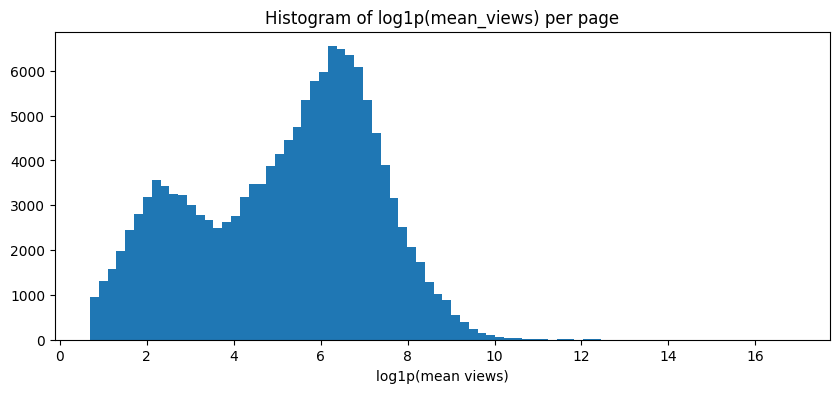

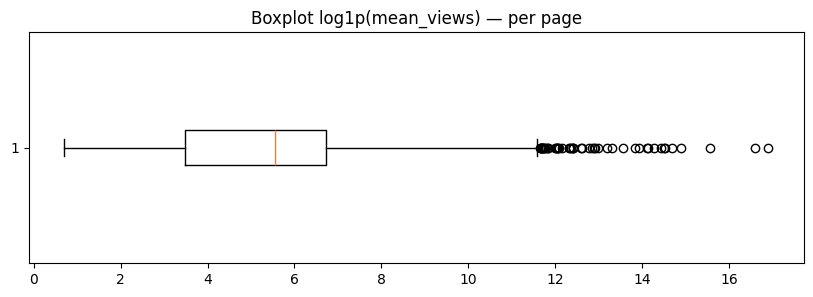

In [ ]:
# page-level stats and distribution
train_clean['mean_views']   = train_clean[date_cols].mean(axis=1)
train_clean['median_views'] = train_clean[date_cols].median(axis=1)
train_clean['std_views']    = train_clean[date_cols].std(axis=1)
train_clean['max_views']    = train_clean[date_cols].max(axis=1)

print("Overall pages:", len(train_clean))
print("mean_views describe:\n", train_clean['mean_views'].describe())

# Histogram (log1p) of mean views across pages
plt.figure(figsize=(10,4))
plt.hist(np.log1p(train_clean['mean_views']), bins=80)
plt.title("Histogram of log1p(mean_views) per page")
plt.xlabel("log1p(mean views)")
plt.show()

# Boxplot (log scale)
plt.figure(figsize=(10,3))
plt.boxplot(np.log1p(train_clean['mean_views']), vert=False)
plt.title("Boxplot log1p(mean_views) — per page")
plt.show()


##### 📊 Page-Level Statistics

- **Total pages:** 144,411  

##### 📈 Page Views (across time, per page)
- **Mean:** ~1.3k views  
- **Median:** ~243 views  
- **Standard Deviation:** ~74k (huge spread, very skewed)  
- **Minimum:** 0  
- **Maximum:** ~21.9M (English *Main_Page* dominates)  

##### ✅ Distribution Insight
- Most pages have **very low views**.  
- A small number of pages have **extremely high values** → heavy-tailed distribution.  


#### top pages by language (top 10 per language)

In [ ]:
# top pages per language by mean_views
top_n = 10
top_by_lang = {}
for lang, grp in train_clean.groupby('Language'):
    top = grp.sort_values('mean_views', ascending=False).head(top_n)[['Page','mean_views','median_views','std_views']]
    top_by_lang[lang] = top
    print(f"\nTop {top_n} for language: {lang}")
    display(top.reset_index(drop=True))



Top 10 for language: commons


,Page,mean_views,median_views,std_views
0,Special:Search_commons.wikimedia.org_all-acces...,122092.069091,121104.5,37751.556596
1,Special:Search_commons.wikimedia.org_desktop_a...,115181.374545,114557.5,38157.668386
2,Special:CreateAccount_commons.wikimedia.org_al...,97809.792727,0.0,185744.991605
3,Main_Page_commons.wikimedia.org_all-access_all...,95876.894545,78989.5,45481.769703
4,Special:CreateAccount_commons.wikimedia.org_de...,87383.689091,0.0,165100.762088
5,Main_Page_commons.wikimedia.org_desktop_all-ag...,71201.678182,53019.5,41287.411011
6,Special:RecentChangesLinked_commons.wikimedia....,51466.065455,17663.5,71225.473499
7,Special:UploadWizard_commons.wikimedia.org_all...,43152.372727,37649.0,26917.116307
8,Special:UploadWizard_commons.wikimedia.org_des...,40015.534545,34848.5,26117.818261
9,Special:RecentChangesLinked_commons.wikimedia....,39845.821818,14758.0,53245.639656



Top 10 for language: de


,Page,mean_views,median_views,std_views
0,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2.916244e+06,2900707.0,256910.331756
1,Wikipedia:Hauptseite_de.wikipedia.org_mobile-w...,2.023071e+06,2027171.0,166525.606202
2,Wikipedia:Hauptseite_de.wikipedia.org_desktop_...,7.763499e+05,777286.0,174396.996081
3,Spezial:Suche_de.wikipedia.org_all-access_all-...,4.062290e+05,412592.0,76104.974892
4,Spezial:Suche_de.wikipedia.org_desktop_all-agents,3.993396e+05,405669.0,77025.689484
5,Spezial:Anmelden_de.wikipedia.org_all-access_a...,7.325783e+04,33561.5,206388.135013
6,Special:Search_de.wikipedia.org_all-access_all...,7.251190e+04,74300.5,16331.940082
7,Spezial:Anmelden_de.wikipedia.org_desktop_all-...,6.428223e+04,29495.5,170863.093824
8,Special:MyPage/toolserverhelferleinconfig.js_d...,5.924537e+04,87593.0,46392.637360
9,Hauptseite_de.wikipedia.org_all-access_all-agents,5.769538e+04,52003.0,55463.914534



Top 10 for language: en


,Page,mean_views,median_views,std_views
0,Main_Page_en.wikipedia.org_all-access_all-agents,2.193851e+07,19457533.0,9.071410e+06
1,Main_Page_en.wikipedia.org_desktop_all-agents,1.595363e+07,12733277.5,9.529194e+06
2,Main_Page_en.wikipedia.org_mobile-web_all-agents,5.734518e+06,5650391.0,1.190981e+06
3,Special:Search_en.wikipedia.org_all-access_all...,2.371053e+06,2150712.0,1.026681e+06
4,Special:Search_en.wikipedia.org_desktop_all-ag...,1.839723e+06,1710496.5,9.548806e+05
5,Special:Search_en.wikipedia.org_mobile-web_all...,5.312052e+05,421291.5,2.929099e+05
6,Special:Book_en.wikipedia.org_all-access_all-a...,2.436239e+05,204387.5,1.269549e+05
7,Special:Book_en.wikipedia.org_desktop_all-agents,2.423380e+05,202568.0,1.267791e+05
8,Main_Page_en.wikipedia.org_all-access_spider,2.345826e+05,121381.0,8.324043e+05
9,Special:Search_en.wikipedia.org_all-access_spider,2.260186e+05,105600.0,6.286577e+05



Top 10 for language: es


,Page,mean_views,median_views,std_views
0,Wikipedia:Portada_es.wikipedia.org_all-access_...,1.366350e+06,1357293.0,233505.247116
1,Wikipedia:Portada_es.wikipedia.org_mobile-web_...,1.027413e+06,1048781.5,166223.581733
2,Especial:Buscar_es.wikipedia.org_all-access_al...,3.536204e+05,340946.0,108688.474925
3,Wikipedia:Portada_es.wikipedia.org_desktop_all...,3.007988e+05,294326.5,111426.730770
4,Especial:Buscar_es.wikipedia.org_desktop_all-a...,2.916932e+05,283037.5,98151.452792
5,Especial:Buscar_es.wikipedia.org_mobile-web_al...,6.192721e+04,59732.5,39916.426989
6,Especial:Entrar_es.wikipedia.org_all-access_al...,6.178793e+04,36568.5,76432.802682
7,Wikipedia:Portada_es.wikipedia.org_all-access_...,5.748256e+04,59707.0,32317.615274
8,Lali_Espósito_es.wikipedia.org_all-access_all-...,4.836852e+04,2331.0,85492.203316
9,Especial:Entrar_es.wikipedia.org_desktop_all-a...,4.681298e+04,22172.5,75204.400566



Top 10 for language: fr


,Page,mean_views,median_views,std_views
0,Wikipédia:Accueil_principal_fr.wikipedia.org_a...,1.579056e+06,1596963.0,107272.168494
1,Wikipédia:Accueil_principal_fr.wikipedia.org_m...,1.111460e+06,1161585.5,146910.701574
2,Wikipédia:Accueil_principal_fr.wikipedia.org_d...,4.356164e+05,360490.0,147265.783900
3,Spécial:Recherche_fr.wikipedia.org_all-access_...,1.739389e+05,175065.0,35781.209825
4,Spécial:Recherche_fr.wikipedia.org_desktop_all...,1.608163e+05,160558.0,35840.766851
5,Sp?cial:Search_fr.wikipedia.org_all-access_all...,1.385356e+05,164142.0,86550.696746
6,Sp?cial:Search_fr.wikipedia.org_desktop_all-ag...,1.385190e+05,164142.0,86543.621300
7,Wikipédia:Accueil_principal_fr.wikipedia.org_a...,1.161105e+05,65613.0,109257.431598
8,Organisme_de_placement_collectif_en_valeurs_mo...,6.663260e+04,152.5,458745.490780
9,Organisme_de_placement_collectif_en_valeurs_mo...,6.658935e+04,115.0,458728.976380



Top 10 for language: ja


,Page,mean_views,median_views,std_views
0,メインページ_ja.wikipedia.org_all-access_all-agents,383188.718182,376056.0,47683.407404
1,メインページ_ja.wikipedia.org_desktop_all-agents,243904.390909,241206.0,41216.826842
2,特別:検索_ja.wikipedia.org_all-access_all-agents,127848.961818,125461.0,34110.227287
3,特別:検索_ja.wikipedia.org_desktop_all-agents,125845.829091,123722.5,34098.613224
4,メインページ_ja.wikipedia.org_mobile-web_all-agents,120834.767273,117877.5,14531.007331
5,特別:最近の更新_ja.wikipedia.org_all-access_all-agents,32114.165455,24564.0,21238.063878
6,特別:最近の更新_ja.wikipedia.org_desktop_all-agents,32050.220000,24512.0,21231.249548
7,真田信繁_ja.wikipedia.org_all-access_all-agents,19623.707273,11398.0,25331.128196
8,特別:外部リンク検索_ja.wikipedia.org_all-access_all-agents,18783.983636,13894.0,19034.972093
9,特別:外部リンク検索_ja.wikipedia.org_desktop_all-agents,18778.030909,13894.0,19030.157327



Top 10 for language: ru


,Page,mean_views,median_views,std_views
0,Заглавная_страница_ru.wikipedia.org_all-access...,1.974581e+06,1352373.0,2.856762e+06
1,Заглавная_страница_ru.wikipedia.org_desktop_al...,1.350691e+06,702277.5,2.879428e+06
2,Заглавная_страница_ru.wikipedia.org_mobile-web...,5.962372e+05,608367.5,9.248421e+04
3,Служебная:Поиск_ru.wikipedia.org_all-access_al...,1.886623e+05,181508.5,7.765982e+04
4,Служебная:Поиск_ru.wikipedia.org_desktop_all-a...,1.793894e+05,172320.5,7.730592e+04
5,Служебная:Ссылки_сюда_ru.wikipedia.org_all-acc...,4.564001e+04,17462.0,5.520397e+04
6,Служебная:Ссылки_сюда_ru.wikipedia.org_desktop...,4.556028e+04,17392.0,5.520756e+04
7,Special:Search_ru.wikipedia.org_all-access_all...,4.431740e+04,27331.0,8.923381e+04
8,Special:Search_ru.wikipedia.org_desktop_all-ag...,3.992449e+04,22068.5,8.901372e+04
9,Служебная:Вход_ru.wikipedia.org_all-access_all...,2.211379e+04,15828.5,2.993972e+04



Top 10 for language: www


,Page,mean_views,median_views,std_views
0,MediaWiki_www.mediawiki.org_all-access_all-agents,31103.154545,29155.5,13951.541104
1,MediaWiki_www.mediawiki.org_desktop_all-agents,24010.001818,22207.0,13825.900827
2,Parsoid/Developer_Setup_www.mediawiki.org_all-...,8508.330909,52.5,83038.008700
3,Parsoid/Developer_Setup_www.mediawiki.org_desk...,8506.445455,51.0,83037.934646
4,MediaWiki_www.mediawiki.org_mobile-web_all-agents,7093.152727,6859.0,1289.804504
5,Special:MyLanguage/Help:Logging_in_www.mediawi...,6969.269091,8378.5,5260.058865
6,Special:MyLanguage/Help:Logging_in_www.mediawi...,6641.307273,7908.0,5107.747762
7,Special:MyLanguage/How_to_contribute_www.media...,6551.185455,5258.5,7361.656744
8,Download_www.mediawiki.org_all-access_all-agents,5789.940000,5728.5,670.622188
9,Download_www.mediawiki.org_desktop_all-agents,5697.740000,5619.0,688.865909



Top 10 for language: zh


,Page,mean_views,median_views,std_views
0,Wikipedia:首页_zh.wikipedia.org_all-access_all-a...,224898.749091,218543.0,33800.241285
1,Wikipedia:首页_zh.wikipedia.org_desktop_all-agents,120792.074545,120227.0,16697.201658
2,Wikipedia:首页_zh.wikipedia.org_mobile-web_all-a...,92522.598182,83800.0,27514.332061
3,Special:搜索_zh.wikipedia.org_all-access_all-agents,88505.680000,84724.5,25180.040869
4,Special:搜索_zh.wikipedia.org_desktop_all-agents,87643.350909,83985.0,25159.847079
5,Running_Man_zh.wikipedia.org_all-access_all-ag...,20883.354545,20069.5,8221.567640
6,Special:链接搜索_zh.wikipedia.org_all-access_all-a...,18764.369091,13877.0,19037.493005
7,Special:链接搜索_zh.wikipedia.org_desktop_all-agents,18764.247273,13877.0,19037.508779
8,Running_Man_zh.wikipedia.org_desktop_all-agents,14488.078182,13765.5,5682.706156
9,瑯琊榜_(電視劇)_zh.wikipedia.org_all-access_all-agents,10711.980000,7732.5,9156.584737


##### 📈 Top Pages per Language

- **English (en):**  
  - Dominated by **Main_Page** → >20M average views.  

- **Japanese (ja):**  
  - Top page: **メインページ** → ~383k average views.  

- **German (de):**  
  - Top page: **Wikipedia:Hauptseite** → ~2.9M average views.  

##### ✅ Key Insight
- Across languages, the **homepage / main entry point** is consistently the **most viewed page**.  


#### device & agent breakdown (aggregated view) → Bivariate

In [ ]:
# device & agent breakdowns
# compute total views per page (sum across dates)
train_clean['total_views'] = train_clean[date_cols].sum(axis=1)

# total views by language
lang_agg = train_clean.groupby('Language')['total_views'].agg(['sum','mean','median','count']).sort_values('sum', ascending=False)
print("Per-language total / mean / median / count:\n", lang_agg)

# device (AccessType) breakdown per language (sum)
device_lang = train_clean.groupby(['Language','AccessType'])['total_views'].sum().unstack(fill_value=0)
print("\nDevice breakdown (sum of total_views) per Language:\n")
display(device_lang)

# agent (AccessOrigin) breakdown per language
agent_lang = train_clean.groupby(['Language','AccessOrigin'])['total_views'].sum().unstack(fill_value=0)
print("\nAgent breakdown (sum of total_views) per Language:\n")
display(agent_lang)


Per-language total / mean / median / count:
                    sum          mean    median  count
Language                                             
en        5.874867e+10  2.475922e+06  543944.0  23728
es        9.490190e+09  6.783553e+05  350652.0  13990
de        8.861985e+09  4.832317e+05  146402.0  18339
ja        8.571286e+09  4.217945e+05  221499.0  20321
ru        7.998352e+09  5.355083e+05  243498.0  14936
fr        6.377805e+09  3.605928e+05  138933.0  17687
zh        3.171961e+09  1.862791e+05   86884.0  17028
commons   1.049261e+09  1.095833e+05   15704.0   9575
www       2.291383e+08  3.481815e+04    6912.0   6581

Device breakdown (sum of total_views) per Language:



AccessType,all-access,desktop,mobile-web
Language,,,
commons,5.465958e+08,3.854569e+08,1.172077e+08
de,4.497298e+09,2.004061e+09,2.360627e+09
en,2.963592e+10,1.730906e+10,1.180369e+10
es,4.771322e+09,2.171337e+09,2.547531e+09
fr,3.249986e+09,1.508083e+09,1.619735e+09
ja,4.377223e+09,1.597379e+09,2.596684e+09
ru,4.025646e+09,2.469713e+09,1.502993e+09
www,1.222178e+08,9.418572e+07,1.273474e+07
zh,1.605778e+09,9.478700e+08,6.183132e+08



Agent breakdown (sum of total_views) per Language:



AccessOrigin,all-agents,spider
Language,,
commons,9.945551e+08,54705447.0
de,8.780998e+09,80987292.0
en,5.817430e+10,574370268.0
es,9.400286e+09,89904305.0
fr,6.265552e+09,112253372.0
ja,8.337674e+09,233612068.0
ru,7.930091e+09,68261022.0
www,2.134444e+08,15693843.0
zh,3.125570e+09,46390392.0


##### 🌍 Language Totals
- **English (en):** ~5.87e10 views (≈59B, by far the largest)  
- **Spanish (es):** ~9.49e9  
- **German (de):** ~8.86e9  
- **Japanese (ja):** ~8.57e9  
- **Russian (ru):** ~7.99e9  
- Then **French (fr), Chinese (zh), etc.** follow.  

---

##### 💻 Device Breakdown (AccessType – English example)
- **All-access total:** ~29.6B  
- **Desktop:** ~17.3B  
- **Mobile-web:** ~11.8B  
- 📌 **Insight:** For English, **desktop > mobile-web** in this dataset.  

---

##### 🤖 Agent Breakdown (AccessOrigin – English example)
- **All-agents total:** ~58.1B  
- **Spider (bots/crawlers):** ~574M  
- 📌 **Insight:** Spiders account for **<1% of total traffic**.  


### time-series aggregate per language (daily totals) & plot

lang_daily shape (dates x languages): (550, 9)


Language,commons,de,en,es,fr,ja,ru,www,zh
2015-07-01,1140655.0,13260512.0,84712136.0,15278549.0,8458638.0,11863198.0,9463846.0,349630.0,4144988.0
2015-07-02,1177955.0,13079896.0,84438494.0,14601012.0,8512948.0,13620791.0,9627637.0,383609.0,4151183.0
2015-07-03,1150360.0,12554041.0,80167646.0,13427631.0,8186029.0,12305383.0,8923451.0,325634.0,4123651.0
2015-07-04,951111.0,11520376.0,83463142.0,12606538.0,8749839.0,15456239.0,8393202.0,308658.0,4163446.0
2015-07-05,1057864.0,13392345.0,86198561.0,13710355.0,8590490.0,14827203.0,8938519.0,338390.0,4441283.0


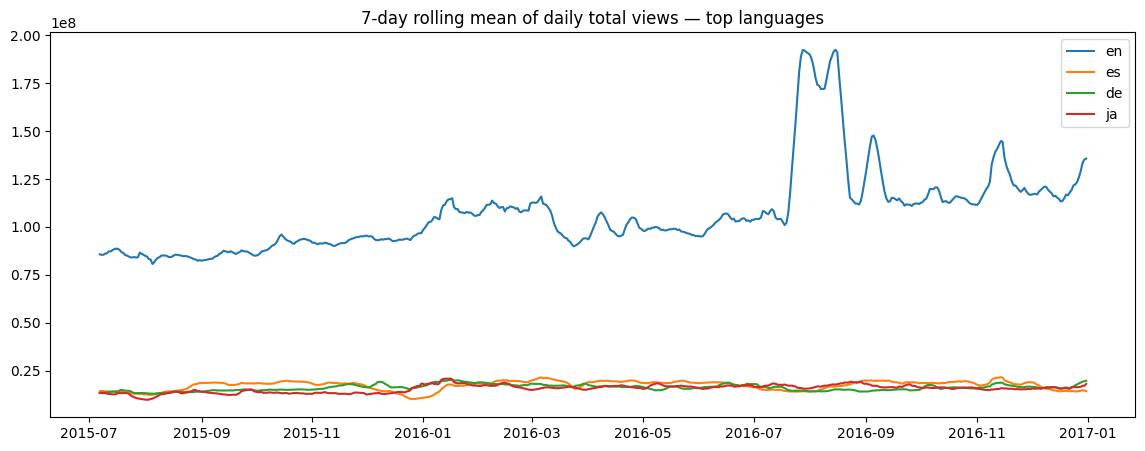

In [ ]:
# daily aggregate per language (memory efficient)
# compute daily totals by language: result will be DataFrame indexed by dates with languages as columns
lang_daily = train_clean.groupby('Language')[date_cols].sum().T
lang_daily.index = pd.to_datetime(lang_daily.index)
print("lang_daily shape (dates x languages):", lang_daily.shape)
display(lang_daily.head())

# Plot daily totals for top 4 languages by total views
top_langs = lang_agg.sort_values('sum', ascending=False).head(4).index.tolist()
plt.figure(figsize=(14,5))
for lang in top_langs:
    plt.plot(lang_daily.index, lang_daily[lang].rolling(7).mean(), label=lang)
plt.legend()
plt.title("7-day rolling mean of daily total views — top languages")
plt.show()


#### 📊 Plot Interpretation

- **English (en):**  
  - Completely dominates with **~80M–100M daily views**, spiking above **150M mid-2016**.  
  - Noticeable **traffic spikes around July–Sept 2016** (likely global events driving traffic).  

- **Spanish (es), German (de), Japanese (ja):**  
  - Much smaller scale (**~10M–20M daily views**).  
  - Stay relatively steady without such large anomalies.  

##### ✅ Key Takeaway
- **English Wikipedia** drives the majority of traffic and shows sensitivity to **global events/news**.  
- **Other languages** are steady and less volatile, reflecting more consistent regional usage patterns.  


### day-of-week pattern (weekday seasonality)

Average daily views by weekday for top languages:



Language,en,es,de,ja
weekday,,,,
Monday,1.143724e+08,1.863006e+07,1.721892e+07,1.576457e+07
Tuesday,1.087327e+08,1.929836e+07,1.642143e+07,1.500169e+07
Wednesday,1.067325e+08,1.924489e+07,1.611172e+07,1.479259e+07
Thursday,1.042354e+08,1.817305e+07,1.578001e+07,1.483169e+07
Friday,1.008865e+08,1.578649e+07,1.556399e+07,1.546786e+07
Saturday,1.030852e+08,1.379658e+07,1.475151e+07,1.607654e+07
Sunday,1.098236e+08,1.588069e+07,1.697009e+07,1.716912e+07


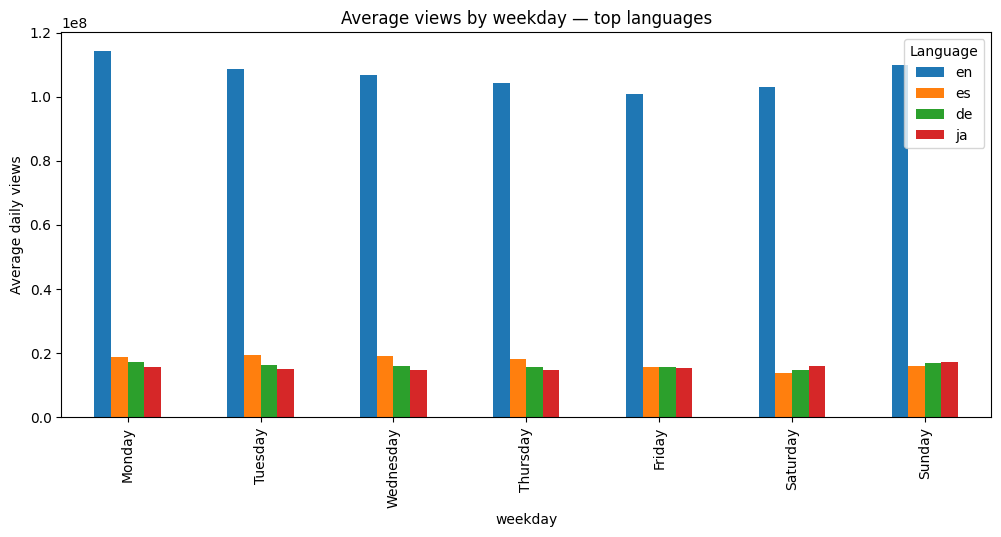

In [ ]:
# day-of-week effect
lang_daily['weekday'] = lang_daily.index.day_name()
weekday_avg = lang_daily.groupby('weekday')[top_langs].mean()

# reorder weekdays
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_avg = weekday_avg.reindex(order)

print("Average daily views by weekday for top languages:\n")
display(weekday_avg)

# plot
weekday_avg.plot(kind='bar', figsize=(12,5))
plt.title("Average views by weekday — top languages")
plt.ylabel("Average daily views")
plt.show()


#### 🔎 Key Patterns in Page Views by Language

- English (en)
  - **Pattern:** Peak on **Monday**, gradual decline toward **Friday**, slight rebound on **weekends**.  
  - **Interpretation:** Strong weekday usage (likely work/school related).  

- Spanish (es)
  - **Pattern:** Peaks on **Tuesday/Wednesday**, lowest on **weekends**.  
  - **Interpretation:** Stronger weekday preference.  

- German (de)
  - **Pattern:** Similar weekday pattern as English, but **Sunday rebound** is stronger.  
  - **Interpretation:** Mix of weekday usage with higher weekend engagement.  

- Japanese (ja)
  - **Pattern:** Lowest on **Wednesday–Thursday**, highest on **Sunday**.  
  - **Interpretation:** More **leisure/weekend usage** compared to Western patterns.  

---

#### ✅ Cultural Insight
- **English/Spanish** → **Weekday-heavy**, likely work/study driven.  
- **German/Japanese** → **Weekend engagement** is stronger, with cultural differences in browsing habits.  


### sample pages for deep dive (pick top + random + low traffic)

##### 📑 Page Selection Rules per Language

For each language:  

1. **Top 2 pages** with highest **mean views** (`top_k = 2`)  
2. **Top 1 page** with highest **variance** (`var_k = 1`)  
3. **Bottom 1 page** with lowest **mean views** (`rand_k = 1`)  

👉 That’s **4 pages per language** (though `dict.fromkeys` can remove duplicates if overlaps occur).  

- With **4 languages** (`en, es, de, ja`):  
  - Maximum = **4 × 4 = 16 pages**.  


In [ ]:
# pick representative pages to inspect deeply
# selection strategy: top by mean, high-variance, and random low-traffic
def pick_pages_for_lang(df, lang, top_k=2, var_k=1, rand_k=1, seed=42):
    grp = df[df['Language']==lang]
    top = grp.sort_values('mean_views', ascending=False).head(top_k)['Page'].tolist()
    high_var = grp.sort_values('std_views', ascending=False).head(var_k)['Page'].tolist()
    low = grp.sort_values('mean_views', ascending=True).head(rand_k)['Page'].tolist()
    return list(top + high_var + low)  # order is not unique
    # return list(dict.fromkeys(top + high_var + low))  # keep order unique

sample_pages = []
for lang in top_langs:
    sample_pages += pick_pages_for_lang(train_clean, lang, top_k=2, var_k=1, rand_k=1)

print("Sample pages to inspect across languages (for time series plots):")
print(sample_pages)

# # plot them
# for page in sample_pages:
#     row = train_clean[train_clean['Page']==page].iloc[0]
#     s = row[date_cols].astype(float)
#     s.index = pd.to_datetime(date_cols)
#     plt.figure(figsize=(12,3))
#     plt.plot(s.index, s.values)
#     plt.title(f"{page} — mean {row['mean_views']:.2f} | std {row['std_views']:.2f}")
#     plt.show()


Sample pages to inspect across languages (for time series plots):
['Main_Page_en.wikipedia.org_all-access_all-agents', 'Main_Page_en.wikipedia.org_desktop_all-agents', 'Main_Page_en.wikipedia.org_desktop_all-agents', 'Adelisa_Grabus_en.wikipedia.org_all-access_all-agents', 'Wikipedia:Portada_es.wikipedia.org_all-access_all-agents', 'Wikipedia:Portada_es.wikipedia.org_mobile-web_all-agents', 'Wikipedia:Portada_es.wikipedia.org_all-access_all-agents', 'Donald_Trump_Jr._es.wikipedia.org_all-access_spider', 'Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents', 'Wikipedia:Hauptseite_de.wikipedia.org_mobile-web_all-agents', 'Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents', 'Kellyanne_Conway_de.wikipedia.org_all-access_spider', 'メインページ_ja.wikipedia.org_all-access_all-agents', 'メインページ_ja.wikipedia.org_desktop_all-agents', 'キングオブコメディ_ja.wikipedia.org_all-access_all-agents', 'MediaWiki:EnhancedCollapsibleElements.js_ja.wikipedia.org_all-access_spider']


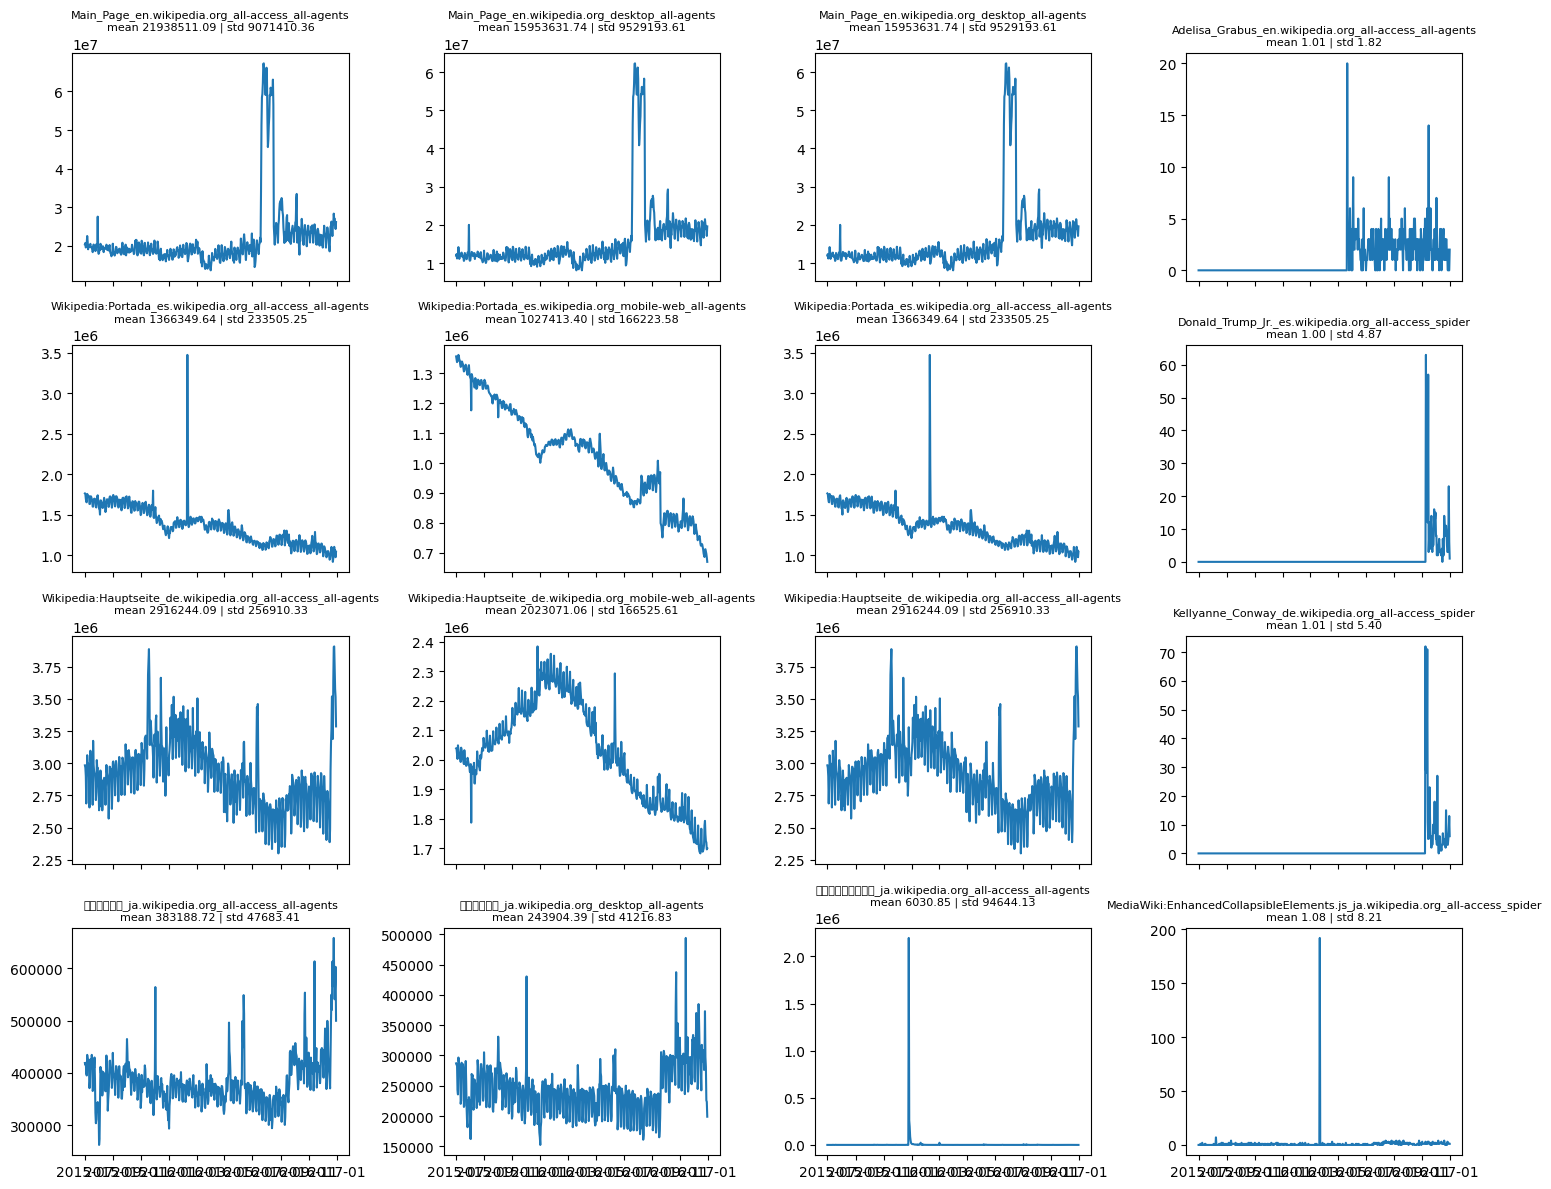

In [ ]:
import math

n = len(sample_pages)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows*3), sharex=True)
axes = axes.flatten()

for i, page in enumerate(sample_pages):
    row = train_clean[train_clean['Page']==page].iloc[0]
    s = row[date_cols].astype(float)
    s.index = pd.to_datetime(date_cols)

    axes[i].plot(s.index, s.values)
    axes[i].set_title(f"{page}\nmean {row['mean_views']:.2f} | std {row['std_views']:.2f}", fontsize=8)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])  # remove unused subplots

plt.tight_layout()
plt.show()


In [ ]:
# # Save critical CSVs for reproducibility
# lang_agg.to_csv('lang_agg_summary.csv')
# for lang, df in top_by_lang.items():
#     df.to_csv(f"top_pages_{lang}.csv", index=False)
# lang_daily.to_csv('lang_daily.csv')

#### 📌 Actionable Insights (3–5 points)

1. **Language traffic dominance**  
   - English Wikipedia drives the majority of global traffic (~100M+ daily views).  
   - Spanish (~18–19M), German (~15–17M), and Japanese (~15–17M) form the second tier.  
   - 👉 Campaign targeting should prioritize **English first**, then Spanish/German/Japanese.  

2. **Device usage split**  
   - Spanish & Japanese: **mobile-web dominates**.  
   - English: **balanced** desktop vs. mobile.  
   - German: leans **desktop-first**.  
   - 👉 Non-English campaigns should be **mobile-first**, while English/German can support cross-device.  

3. **Weekday patterns**  
   - English peaks **Mon–Tue**, dips **Fri–Sat**.  
   - Japanese rises into **weekends (Sat–Sun)**.  
   - German & Spanish relatively **stable**, but slight midweek dips.  
   - 👉 Campaign launch timing should align with **local audience rhythms**.  

4. **Main page dominance**  
   - Language homepages (Main_Page_en, Wikipedia:Portada_es, etc.) absorb **disproportionate traffic**.  
   - 👉 Treat these as **traffic hubs** and monitor separately from article traffic.  

---

#### 📊 Visualization Takeaways (3 key inferences)

1. **Language dominance**  
   - EN: ~100–114M avg daily views  
   - ES: ~18–19M  
   - DE: ~15–17M  
   - JA: ~15–17M  
   - ➡️ English has ~**6× more traffic** than the next language.  

2. **Device split**  
   - Spanish & Japanese: **mobile-heavy**.  
   - English: **balanced split**.  
   - German: **desktop-skewed**.  
   - ➡️ Clear implication for **ad/channel strategy**.  

3. **Weekday effect**  
   - English → early-week heavy (Mon–Tue), lighter Fri–Sat.  
   - Japanese → weekend uplift.  
   - German/Spanish → steady, mild midweek dips.  
   - ➡️ Campaign timing should **adapt per-language**.  


### 🔹 Save train_clean to file

In [ ]:
save_path = "/content/drive/My Drive/Wikipedia/"


train_clean.to_csv(save_path + "train_clean.csv", index=False)
train_clean.to_parquet(save_path + "train_clean.parquet", index=False)

## ✅ Summary of Flow

1. **Import & Inspect Data**  
2. **Parse Page Names** → add metadata (title, language, access type, origin)  
3. **Exploratory Data Analysis (EDA)** → visualize distributions, compare languages  
4. **Reshape Data for Time Series** → pivot into `(date, views)` format  
5. **Stationarity Tests** → ADF test, decomposition, differencing  
6. **Modeling** → ARIMA → SARIMAX → Prophet  
7. **Evaluation** → MAPE for accuracy comparison  
8. **Multi-Series Pipeline** → reusable functions across languages  
9. **Final Insights & Questionnaire** → visual inferences, model differences, alternative selections  


### 📊 AdEase Time-Series Modeling

Explore the full time-series forecasting workflow — including ARIMA, SARIMAX, and Prophet model comparisons — in the following Colab notebook:

[🔗 Open AdEase Time-Series Modeling Notebook in Google Colab](https://colab.research.google.com/drive/13y0h8tMvqw8_c0UUnRJQ2YTZoyvXWODq?usp=sharing)

  - https://colab.research.google.com/drive/13y0h8tMvqw8_c0UUnRJQ2YTZoyvXWODq?usp=sharing
